In [1]:
"""
Filename: main.ipynb
Author: Alexay Mehra
Date: 2025-09-12
Description: Main file for testing, contains the following:
- Image of the Morse Potential to fit
- Code block to run the optimization function
- Visuals to compare synthesized time evolution with true time evolution
"""

'\nFilename: main.ipynb\nAuthor: Alexay Mehra\nDate: 2025-09-12\nDescription: Main file for testing, contains the following:\n- Image of the Morse Potential to fit\n- Code block to run the optimization function\n- Visuals to compare synthesized time evolution with true time evolution\n'

In [7]:
# Imports

import os, sys
sys.path.append(os.path.abspath("../src"))

import numpy as np
import scipy as sp
from qutip import coherent

from utils import time, N
from optimization import gate_seq, fidelity_loss, morse_to_optimize, run_optimization, print_optimal_params
from visualization import plot_potential, generate_wavefunc, gen_wigfunc

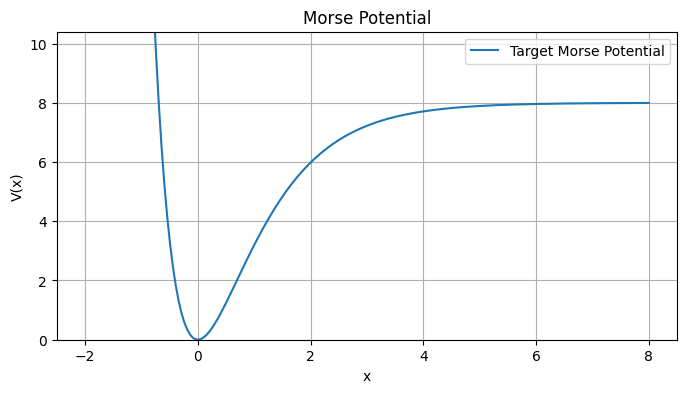

In [8]:
#Plot the Morse Potential
plot_potential()

In [9]:
# Run the Optimization

d = 6 # gate depth
optimal_params = run_optimization(d, 'coordinate-descent', 5)
print_optimal_params(optimal_params, d)

# The function value returned is the infidelity (lower is better)
infid = fidelity_loss(optimal_params, d, morse_to_optimize)
print("Exact Infidelity:", infid)

Optimized alpha_real, Iteration 0
Current Infidelity: 0.5836901118363105

Optimized alpha_imag, Iteration 0
Current Infidelity: 0.5826784863536261

Optimized theta, Iteration 0
Current Infidelity: 0.5576207280705595

Optimized phi, Iteration 0
Current Infidelity: 0.5576196322763358

Optimized alpha_real, Iteration 1
Current Infidelity: 0.5564574297457738

Optimized alpha_imag, Iteration 1
Current Infidelity: 0.5555479957147975

Optimized theta, Iteration 1
Current Infidelity: 0.5555469289077061

Optimized phi, Iteration 1
Current Infidelity: 0.5555460998125575

Optimized alpha_real, Iteration 2
Current Infidelity: 0.5546587219622013

Optimized alpha_imag, Iteration 2
Current Infidelity: 0.553794120801674

Optimized theta, Iteration 2
Current Infidelity: 0.5537932953336363

Optimized phi, Iteration 2
Current Infidelity: 0.5537926343216827

Optimized alpha_real, Iteration 3
Current Infidelity: 0.5529528576402024

Optimized alpha_imag, Iteration 3
Current Infidelity: 0.5521355899232283

O

In [10]:
# Build the synthesized unitary and extract the Hamiltonian
morse_generated = gate_seq(optimal_params, d)               
generated_hamiltonian = (1j / time) * sp.linalg.logm(morse_generated) 

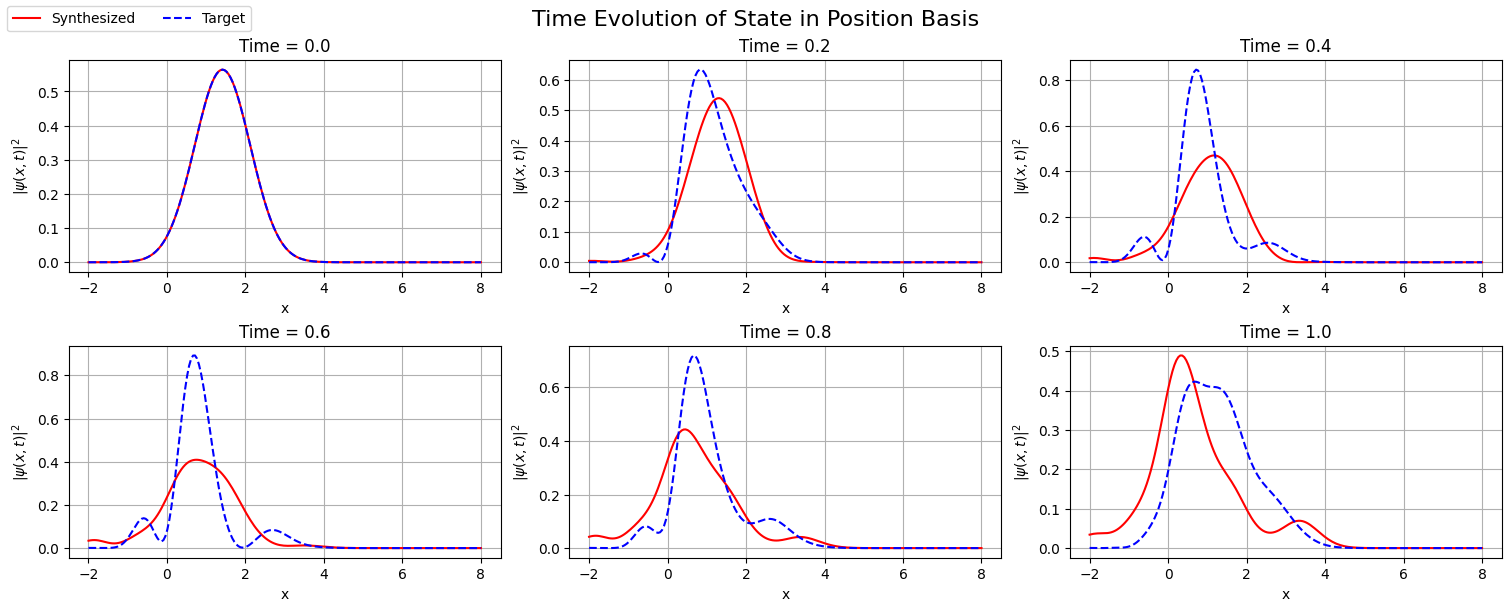

In [12]:
# Generate Wavefunction Graphics

target_time = 1 # End time to be visualized for the wavefunction
n_steps = 6     # number of time steps to visualize

# --- Choose Initial State ---

# Choose the Initial State for the Qubit
init_qubit_state = np.array([1, 0], dtype=complex)

# Choose the Initial State for the Qumode

# Option 1: Fock state
#fock_state_index = 2
#init_qumode_state = np.zeros(N, dtype=complex)
#init_qumode_state[fock_state_index] = 1.0

# Option 2: Coherent state
from qutip import coherent
alpha = 1.0 + 0.5j
init_qumode_state = coherent(N, alpha).full().flatten()

generate_wavefunc(init_qubit_state, init_qumode_state, target_time, n_steps, generated_hamiltonian)

Fidelity at t = 0.00: 1.000000
Fidelity at t = 0.17: 0.912527
Fidelity at t = 0.33: 0.695651
Fidelity at t = 0.50: 0.461562
Fidelity at t = 0.67: 0.307153
Fidelity at t = 0.83: 0.251097
Fidelity at t = 1.00: 0.248798


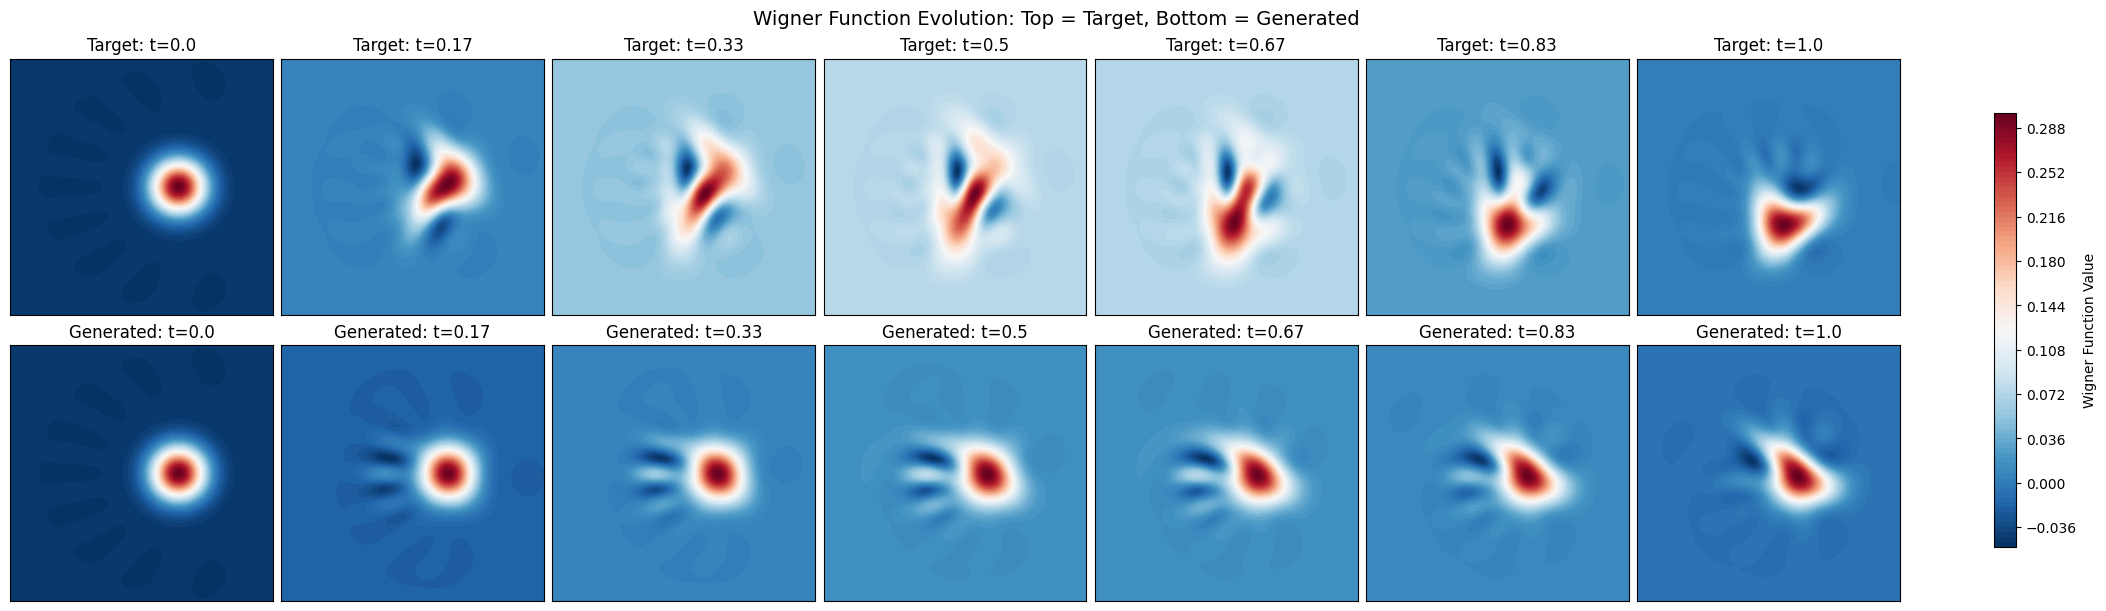

In [11]:
# Generate Wigner Function Graphics

time_and_extra = 1     # end time to be visualized for the wigner function
steps = 6              # number of steps to visualize

# --- Choose Initial State ---

# Choose the Initial State for the Qubit
wig_init_qubit_state = np.array([1, 0], dtype=complex)

# Choose the Initial State for the Qumode

# Option 1: Fock state
# wig_fock_state_index = 2
# wig_init_qumode_state = np.zeros(N, dtype=complex)
# wig_init_qumode_state[fock_state_index] = 1.0

# Option 2: Coherent state
coherent_alpha = 1.0
wig_init_qumode_state = coherent(N, coherent_alpha).full().flatten()

gen_wigfunc(wig_init_qubit_state, wig_init_qumode_state, time_and_extra, steps, generated_hamiltonian)